# BentoML Example: PyTorch Fashion MNIST Classification


[BentoML](http://bentoml.ai) is an open source platform for machine learning model serving and deployment. In this project we will use BentoML to package the image classifier model, and build a containerized REST API model server.

This notebook demonstrates how to use BentoML to turn a PyTorch model into a docker image containing a REST API server serving this model, how to use your ML service built with BentoML as a CLI tool, and how to distribute it a pypi package.

This example was built based on https://github.com/baldassarreFe/zalando-pytorch/blob/master/notebooks/4.0-fb-autoencoder.ipynb, if you are familiar with this, jump start to [Model Serving using BentoML](#Define-ML-service-with-BentoML)

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=pytorch&ea=pytorch-fashion-mnist&dt=pytorch-fashion-mnist)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install -q bentoml
!pip install -q torch torchvision sklearn pillow pandas numpy

In [1]:
import bentoml
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
from torch.autograd import Variable

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

print("Torch version: ", torch.__version__)
print("CUDA: ", torch.cuda.is_available())

Torch version:  1.6.0
CUDA:  False


## Prepare Dataset

PyTorch supports FashionMNIST now, so we can import it directly.

In [2]:
from torchvision.datasets import FashionMNIST
FASHION_MNIST_CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Load train and test set in batches of 1000.

The `28x28` images are scaled up to `29x29` so that combining convolutions and transposed convolutions would not chop off pixels from the reconstructed images.

In [3]:
batch_size = 1000

train_dataset = FashionMNIST(
    '../data', train=True, download=True, 
    transform=transforms.Compose([transforms.CenterCrop((29, 29)), transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = FashionMNIST(
    '../data', train=False, download=True, 
    transform=transforms.Compose([transforms.CenterCrop((29, 29)), transforms.ToTensor()]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw
Processing...


/usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


## Unsupervised reconstruction
Note that in this section we'll never use the image labels, the whole training is unsupervised.

### Autoencoder
The two components of the autoencoder are defined subclassing `nn.Module`, that gives more flexibility than `nn.Sequential`.

#### Encoder
A series of convolutions with `kernel_size=5` and `stride=2` is used to squeeze the images into a volume of 40x1x1, then a fully connected layer turns this vector in a vector of size `embedding_size`, that can be specified externally.

#### Decoder
The decoder takes up from where the encoder left, first transforming back the embedding of size `embedding_size` into a volume of size 40x1x1, then applying a series of Transposed Convolutions to yield an image of the same size of the original input.

At this time we can show some images in this Dataloader.

In [4]:
class Encoder(nn.Module):
    def __init__(self, embedding_size):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(20, 40, kernel_size=5, stride=2)
        self.fully = nn.Linear(40, embedding_size)

    def forward(self, x):
        # 1x29x29
        x = torch.relu(self.conv1(x))
        # 10x13x13
        x = torch.relu(self.conv2(x))
        # 20x5x5
        x = torch.relu(self.conv3(x))
        # 40x1x1
        x = x.view(x.data.shape[0], 40)
        # 40
        x = self.fully(x)
        # output_size
        return x

class Decoder(nn.Module):
    def __init__(self, input_size):
        super(Decoder, self).__init__()
        self.fully = nn.Linear(input_size, 40)
        self.conv1 = nn.ConvTranspose2d(40, 20, kernel_size=5, stride=2)
        self.conv2 = nn.ConvTranspose2d(20, 10, kernel_size=5, stride=2)
        self.conv3 = nn.ConvTranspose2d(10, 1, kernel_size=5, stride=2)
    
    def forward(self, x):
        x = self.fully(x)
        x = x.view(x.data.shape[0], 40, 1, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x

We are going to use an embedding size of 20, this number has no particular reason, except that it is in the same range of the number of classes. Naively, the network could learn to encode coarse-grained information (i.e. the kind of dress) in half of the embedding vector and then use the other half for fine-grained information.

In [5]:
embedding_size = 20
encoder = Encoder(embedding_size)
decoder = Decoder(embedding_size)

autoencoder = nn.Sequential(encoder, decoder)

#### Sanity check
A 29x29 black and white image passed through the autoencoder should give the same output dimension

In [6]:
x = Variable(torch.ones(1, 1, 29, 29))
e = encoder(x)
d = decoder(e)

print('Input\t ', list(x.data.shape))
print('Embedding', list(e.data.shape))
print('Output\t ', list(d.data.shape))

Input	  [1, 1, 29, 29]
Embedding [1, 20]
Output	  [1, 1, 29, 29]


### Training

In [7]:
autoencoder.train()

loss_fn = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters())
epoch_loss = []

for epoch in range(5):
    batch_loss = []
    for batch_num, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        output = autoencoder(data)
        loss = loss_fn(output, data)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    epoch_loss.append(sum(batch_loss) / len(batch_loss))
    print('Epoch {}:\tloss {:.4f}'.format(epoch, epoch_loss[-1]))

Epoch 0:	loss 0.1335
Epoch 1:	loss 0.0748
Epoch 2:	loss 0.0578
Epoch 3:	loss 0.0391
Epoch 4:	loss 0.0328


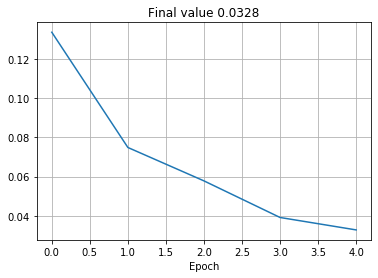

In [8]:
plt.plot(epoch_loss)
plt.title('Final value {:.4f}'.format(epoch_loss[-1]))
plt.xlabel('Epoch')
plt.grid(True)

### Evaluation

Reconsruction evaluation on a single batch

In [9]:
autoencoder.eval()
data, targets = next(test_loader.__iter__())
encodings = encoder(Variable(data))
outputs = decoder(encodings)

print('Test loss: {:.4f}'.format(loss_fn(outputs, Variable(data)).item()))

Test loss: 0.0313


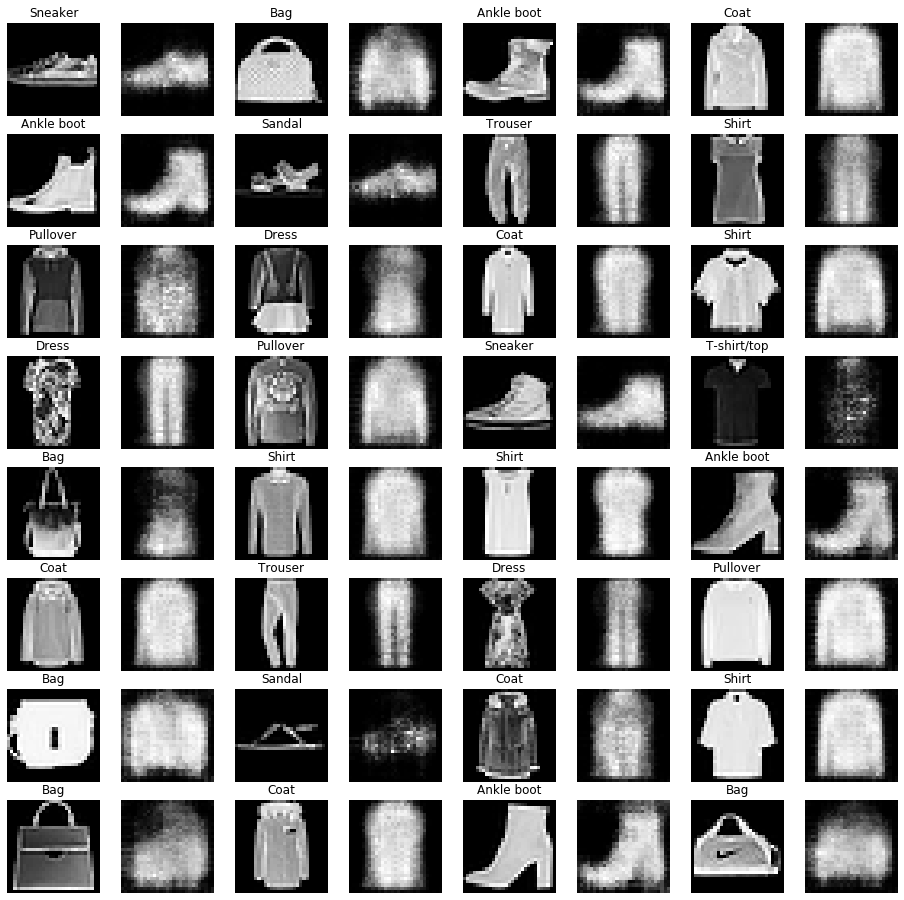

In [10]:
fig, axes = plt.subplots(8, 8, figsize=(16, 16))
axes = axes.ravel()

zip_these = axes[::2], axes[1::2], data.numpy().squeeze(), outputs.data.numpy().squeeze(), targets
for ax1, ax2, original, reconstructed, target in zip(*zip_these):
    ax1.imshow(original, cmap='gray')
    ax1.axis('off')
    ax1.set_title(FASHION_MNIST_CLASSES[target])
    ax2.imshow(reconstructed, cmap='gray')
    ax2.axis('off')

### Embeddings

The embeddings are 20-dimensional, t-SNE is used to visualize them as clusters in 2D space.

Even though the autoencoder learned the embeddings in a completely unsupervised way we can observe the emergence of clusters:
- __shoes__ (sandals, sneakers and ankle boot) are clustered together
- __bags__ form a group on their own (they are the only images with a clear squared-rectangular shape)
- same goes for __trousers__, that form their own group
- all the others are quite mixed together, meaning that the network has learned the concept of _clothes for the upper body_, but is not able to tell a __coat__ from a __pullover__

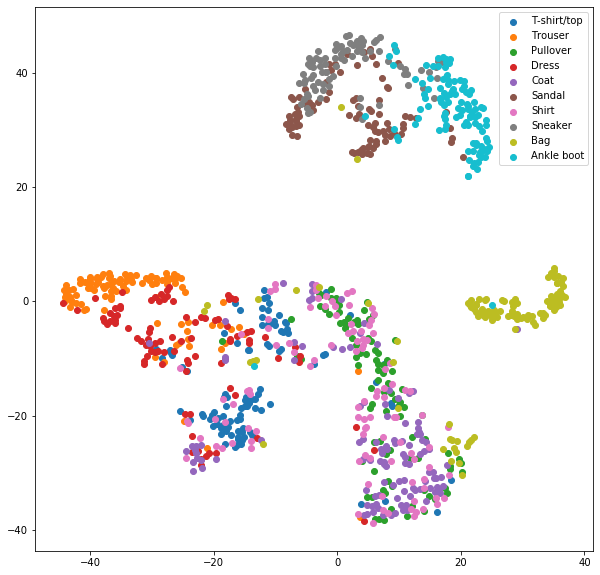

In [11]:
pca = TSNE(n_components=2)
encodings_2 = pca.fit_transform(encodings.data.numpy())
plt.figure(figsize=(10, 10))
for k in range(len(FASHION_MNIST_CLASSES)):
    class_indexes = (targets.numpy() == k)
    plt.scatter(encodings_2[class_indexes, 0], encodings_2[class_indexes, 1], label=FASHION_MNIST_CLASSES[k])
plt.legend();

## Supervised classification

Once trained in an unsupervised fashion, the encoder module can be used to generate _fashion_ embeddings (see what I did here?), that can then be used to train a simple classifier on the original labels.

### Model
The weights of the encoder are freezed, so only the classifier will be trained.

(later on, when the classifier starts performing decently, we could unfreeze them and do some fine-tuning)

In [12]:
for param in encoder.parameters():
    param.requires_grad = False

classifier = nn.Sequential(
    encoder, 
    nn.Linear(embedding_size, 15),
    nn.ReLU(),
    nn.Linear(15, len(FASHION_MNIST_CLASSES)),
    nn.LogSoftmax()
)

### Training

In [13]:
classifier.train()

loss_fn = nn.NLLLoss()
optimizer = optim.Adam([p for p in classifier.parameters() if p.requires_grad])
epoch_loss = []

for epoch in range(5):
    batch_loss = []
    for batch_num, (data, targets) in enumerate(train_loader):
        data, targets = Variable(data), Variable(targets)
        optimizer.zero_grad()
        output = classifier(data)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    epoch_loss.append(sum(batch_loss) / len(batch_loss))
    accuracy = accuracy_score(targets.data.numpy(), output.data.numpy().argmax(axis=1))
    print('Epoch {}:\tloss {:.4f}\taccuracy {:.2%}'.format(epoch, epoch_loss[-1], accuracy))

/usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 0:	loss 2.7176	accuracy 53.30%
Epoch 1:	loss 1.3369	accuracy 57.60%
Epoch 2:	loss 1.1368	accuracy 56.70%
Epoch 3:	loss 1.0524	accuracy 63.50%
Epoch 4:	loss 1.0024	accuracy 59.20%


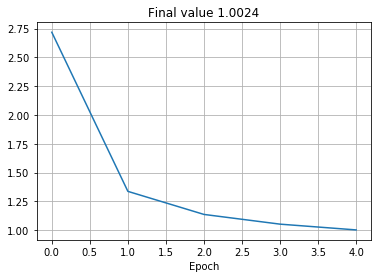

In [14]:
plt.plot(epoch_loss)
plt.title('Final value {:.4f}'.format(epoch_loss[-1]))
plt.xlabel('Epoch')
plt.grid(True)

### Evaluation

Reconsruction evaluation on a single batch

In [15]:
classifier.eval()
data, targets = next(test_loader.__iter__())
outputs = classifier(Variable(data))
log_probs, output_classes = outputs.max(dim=1)

accuracy = accuracy_score(targets.numpy(), output_classes.data.numpy())
print('Accuracy: {:.2%}'.format(accuracy))

Accuracy: 62.20%


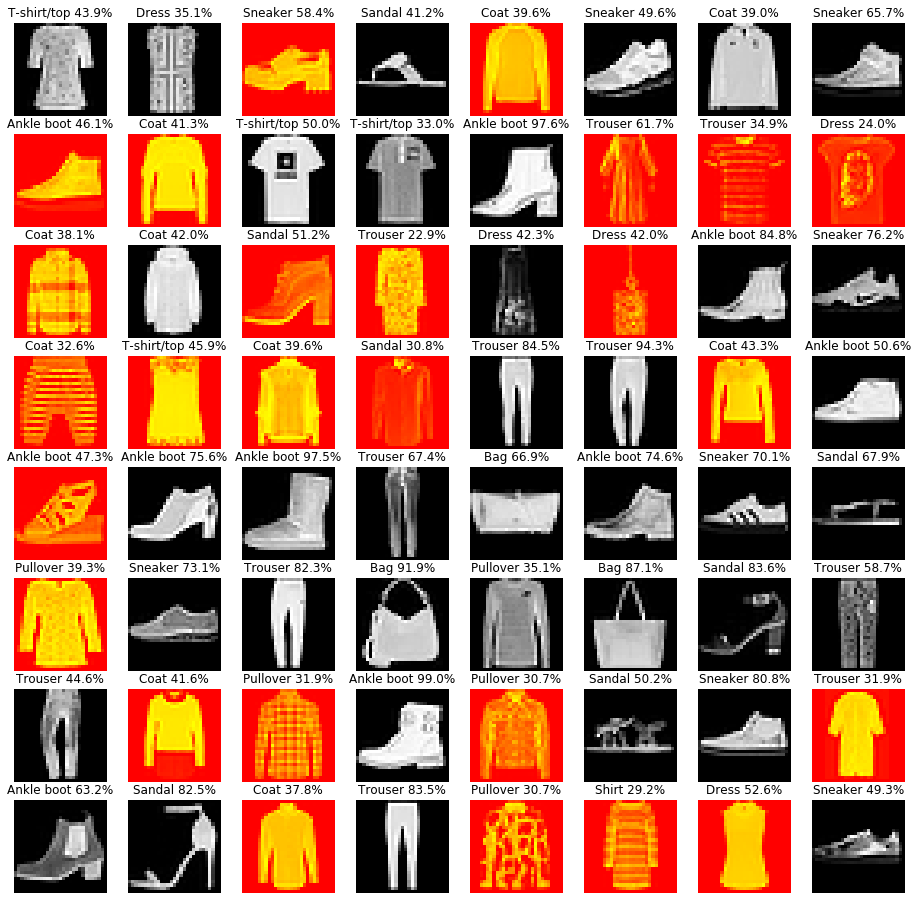

In [16]:
fig, axex = plt.subplots(8, 8, figsize=(16, 16))

zip_these = axex.ravel(), log_probs.data.exp(), output_classes.data, targets, data.numpy().squeeze()
for ax, prob, output_class, target, img in zip(*zip_these):
    ax.imshow(img, cmap='gray' if output_class == target else 'autumn')
    ax.axis('off')
    ax.set_title('{} {:.1%}'.format(FASHION_MNIST_CLASSES[output_class], prob))

## Define BentoService for model serving

In [17]:
%%writefile pytorch_fashion_mnist.py

import bentoml
from PIL import Image
import torch
from torchvision import transforms

from bentoml.artifact import PytorchModelArtifact
from bentoml.adapters import FileInput


FASHION_MNIST_CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


@bentoml.env(pip_dependencies=['torch', 'numpy', 'torchvision', 'scikit-learn'])
@bentoml.artifacts([PytorchModelArtifact('classifier')])
class PyTorchFashionClassifier(bentoml.BentoService):
    
    @bentoml.utils.cached_property  # reuse transformer
    def transform(self):
        return transforms.Compose([transforms.CenterCrop((29, 29)), transforms.ToTensor()])

    @bentoml.api(input=FileInput())
    def predict(self, file_streams):
        img_tensors = []
        for fs in file_streams:
            img = Image.open(fs).convert(mode="L").resize((28, 28))
            img_tensors.append(self.transform(img))
        outputs = self.artifacts.classifier(torch.stack(img_tensors))
        _, output_classes = outputs.max(dim=1)
        
        return [FASHION_MNIST_CLASSES[output_class] for output_class in output_classes]

Overwriting pytorch_fashion_mnist.py


## Save BentoService


In [18]:
# 1) import the custom BentoService defined above
from pytorch_fashion_mnist import PyTorchFashionClassifier

# 2) `pack` it with required artifacts
bento_svc = PyTorchFashionClassifier()
bento_svc.pack('classifier', classifier)

# 3) save your BentoSerivce
saved_path = bento_svc.save()

[2020-09-09 11:35:12,242] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-09 11:35:12,732] WARNING - BentoML by default does not include spacy and torchvision package when using PytorchModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_dependencies=['torchvision'])` when defining a BentoService
[2020-09-09 11:35:13,666] INFO - Detected non-PyPI-released BentoML installed, copying local BentoML modulefiles to target saved bundle path..


no previously-included directories found matching 'e2e_tests'
no previously-included directories found matching 'tests'
no previously-included directories found matching 'benchmark'


UPDATING BentoML-0.8.6+34.g6123b8c6/bentoml/_version.py
set BentoML-0.8.6+34.g6123b8c6/bentoml/_version.py to '0.8.6+34.g6123b8c6'
[2020-09-09 11:35:18,447] INFO - BentoService bundle 'PyTorchFashionClassifier:20200909113513_8A052C' saved to: /Users/bozhaoyu/bentoml/repository/PyTorchFashionClassifier/20200909113513_8A052C


Use `bentoml get <BentoService_Name>` to get list of service versions

In [19]:
!bentoml get PyTorchFashionClassifier

BENTO_SERVICE                                   AGE           APIS                              ARTIFACTS
PyTorchFashionClassifier:20200909113513_8A052C  2.53 seconds  predict<FileInput:DefaultOutput>  classifier<PytorchModelArtifact>


With version info, `bentoml get` display additional information and metadata

In [20]:
!bentoml get PyTorchFashionClassifier:latest

[2020-09-09 11:35:22,740] INFO - Getting latest version PyTorchFashionClassifier:20200909113513_8A052C
{
  "name": "PyTorchFashionClassifier",
  "version": "20200909113513_8A052C",
  "uri": {
    "type": "LOCAL",
    "uri": "/Users/bozhaoyu/bentoml/repository/PyTorchFashionClassifier/20200909113513_8A052C"
  },
  "bentoServiceMetadata": {
    "name": "PyTorchFashionClassifier",
    "version": "20200909113513_8A052C",
    "createdAt": "2020-09-09T18:35:18.400853Z",
    "env": {
      "condaEnv": "name: bentoml-PyTorchFashionClassifier\nchannels:\n- conda-forge\n- defaults\ndependencies:\n- python=3.7.3\n- pip\n",
      "pipDependencies": "torch\nbentoml==0.8.6\nnumpy\ntorchvision\nscikit-learn",
      "pythonVersion": "3.7.3",
      "dockerBaseImage": "bentoml/model-server:0.8.6"
    },
    "artifacts": [
      {
        "name": "classifier",
        "artifactType": "PytorchModelArtifact"
      }
    ],
    "apis": [
      {
        "name": "predict",
        "inputType": "FileInput",
 

Test and validate BentoService with `bentoml run`

In [21]:
!bentoml run PyTorchFashionClassifier:latest predict --input sample_image.png

[2020-09-09 11:35:24,563] INFO - Getting latest version PyTorchFashionClassifier:20200909113513_8A052C
[2020-09-09 11:35:24,602] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-09 11:35:24,615] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.8.6, but loading from BentoML version 0.8.6+34.g6123b8c6
[2020-09-09 11:35:26,575] WARNING - BentoML by default does not include spacy and torchvision package when using PytorchModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_dependencies=['torchvision'])` when defining a BentoService
Exception happened in API function: cannot identify image file <_io.Byt

## Model Serving via REST API

In your termnial, run the following command to start the REST API server:### Run REST API server

In [91]:
!bentoml serve PyTorchFashionClassifier:latest

[2020-08-03 16:54:03,858] INFO - Getting latest version PyTorchFashionClassifier:20200803164836_307D6C
[2020-08-03 16:54:03,859] INFO - Starting BentoML API server in development mode..
[2020-08-03 16:54:05,152] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-08-03 16:54:05,185] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.8.3, but loading from BentoML version 0.8.3+44.gadf1adc.dirty
[2020-08-03 16:54:05,864] WARNING - BentoML by default does not include spacy and torchvision package when using PytorchModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_dependencies=['torchvision'])` when definin

In [ ]:
!bentoml serve-gunicorn PyTorchFashionClassifier:latest --enable-microbatch --workers 1 

[2020-08-03 17:16:51,155] INFO - Getting latest version PyTorchFashionClassifier:20200803171602_556423
[2020-08-03 17:16:51,155] INFO - Starting BentoML API server in production mode..
[2020-08-03 17:16:51,371] INFO - Running micro batch service on :5000
[2020-08-03 17:16:51 +0800] [166176] [INFO] Starting gunicorn 20.0.4
[2020-08-03 17:16:51 +0800] [166161] [INFO] Starting gunicorn 20.0.4
[2020-08-03 17:16:51 +0800] [166176] [INFO] Listening at: http://0.0.0.0:5000 (166176)
[2020-08-03 17:16:51 +0800] [166161] [INFO] Listening at: http://0.0.0.0:44115 (166161)
[2020-08-03 17:16:51 +0800] [166176] [INFO] Using worker: aiohttp.worker.GunicornWebWorker
[2020-08-03 17:16:51 +0800] [166161] [INFO] Using worker: sync
[2020-08-03 17:16:51 +0800] [166177] [INFO] Booting worker with pid: 166177
[2020-08-03 17:16:51 +0800] [166178] [INFO] Booting worker with pid: 166178
[2020-08-03 17:16:51,423] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all co

### Call REST API from a client

Sending POST request from termnial:
```bash
curl -X POST "http://127.0.0.1:5000/predict" -F image=@sample_image.png
```

```bash
curl -X POST "http://127.0.0.1:5000/predict" -H "Content-Type: image/png" --data-binary @sample_image.png
```

Go visit http://127.0.0.1:5000/ from your browser, click `/predict` -> `Try it out` -> `Choose File` -> `Execute` to sumbit an image from your computer

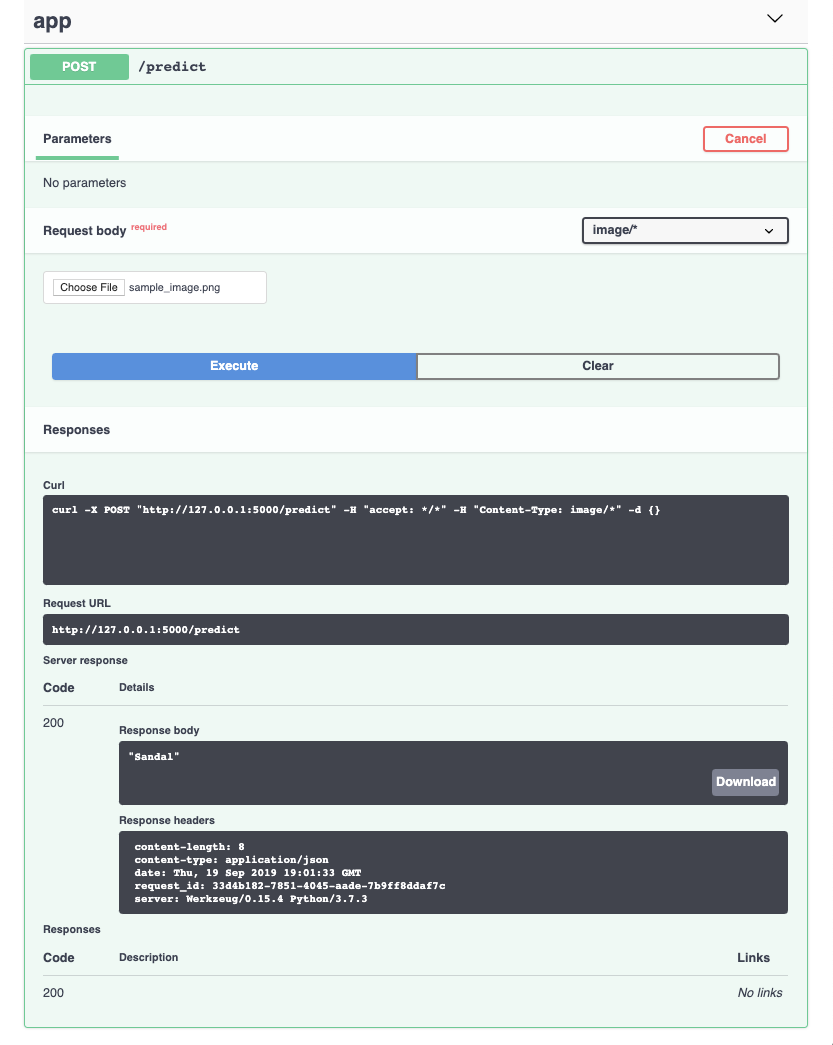

## Use BentoService as PyPI package

In [101]:
!pip install --quiet {saved_path}

In [95]:
!PyTorchFashionClassifier info

{
  "name": "PyTorchFashionClassifier",
  "version": "20200803164836_307D6C",
  "created_at": "2020-08-03T08:48:46.586364Z",
  "env": {
    "conda_env": "name: bentoml-PyTorchFashionClassifier\nchannels:\n- defaults\ndependencies:\n- python=3.6.10\n- pip\n",
    "pip_dependencies": "torch\nbentoml==0.8.3\nnumpy\ntorchvision\nscikit-learn",
    "python_version": "3.6.10",
    "docker_base_image": "bentoml/model-server:0.8.3"
  },
  "artifacts": [
    {
      "name": "classifier",
      "artifact_type": "PytorchModelArtifact"
    }
  ],
  "apis": [
    {
      "name": "predict",
      "input_type": "FileInput",
      "docs": "BentoService inference API 'predict', input: 'FileInput', output: 'DefaultOutput'",
      "output_config": {
        "cors": "*"
      },
      "output_type": "DefaultOutput",
      "mb_max_latency": 10000,
      "mb_max_batch_size": 2000
    }
  ]
}


In [97]:
!PyTorchFashionClassifier run predict --input sample_image.png

/opt/anaconda3/envs/bentoml-dev-py36/lib/python3.6/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Ankle boot


## Containerize REST API server with Docker

** _Make sure you have `docker` installed, note that it is not available when running in Google Colaboratory_

In [103]:
!bentoml containerize PyTorchFashionClassifier:latest

sha256:6c1269967800249676fb0e54b675ddf9647aac3320ab772b32f30cfd7a025545


In [104]:
!docker run -p 5000:5000 pytorch-fashion-mnist

[2020-08-03 09:13:26,158] INFO - Starting BentoML API server in production mode..
[2020-08-03 09:13:26,634] INFO - get_gunicorn_num_of_workers: 3, calculated by cpu count
[2020-08-03 09:13:26 +0000] [1] [INFO] Starting gunicorn 20.0.4
[2020-08-03 09:13:26 +0000] [1] [INFO] Listening at: http://0.0.0.0:5000 (1)
[2020-08-03 09:13:26 +0000] [1] [INFO] Using worker: sync
[2020-08-03 09:13:26 +0000] [12] [INFO] Booting worker with pid: 12
[2020-08-03 09:13:26 +0000] [13] [INFO] Booting worker with pid: 13
[2020-08-03 09:13:26 +0000] [14] [INFO] Booting worker with pid: 14
[2020-08-03 09:13:27,638] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-08-03 09:13:27,652] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together wit

## Deployments

BentoML provides a set of APIs and CLI commands for automating cloud deployment workflow which gets your BentoService API server up and running in the cloud, and allows you to easily update and monitor the service. Currently BentoML have implemented this workflow for AWS Lambda, AWS Sagemaker and Azure Functions. More platforms such as AWS EC2, Kubernetes Cluster, Azure Virtual Machines are on our roadmap.

You can also manually deploy the BentoService API Server or its docker image to cloud platforms, and we’ve created a few step by step tutorials for doing that. You can visit those tutorials at BentoML documentation webiste, or click this [link](https://docs.bentoml.org/en/latest/deployment/index.html)